# Code for the assignment

In [193]:
import networkx as nx
import numpy as np
import scipy as sp
from random import choice, sample
import sys
import math
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

## 1 Epidemic on a known graph

### Problem 1.1

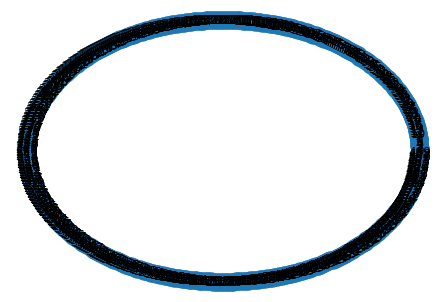

In [96]:
n_nodes = 500
k_regular = nx.circulant_graph(n_nodes, [1,2])
nx.draw_circular(k_regular, with_labels=True)
#[n for n in k_regular.neighbors(300)]

In [113]:
def simulate(graph, n_nodes, initial_infected, n_simulations, n_weeks, beta, ro):

  # Vectors for storing a particular type of node:
  # i^th row corresponds to the i^th simulation,
  # j^th column corresponds to the j^th week
  susceptible_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  infected_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  recovered_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  new_infected_nodes = np.zeros((n_simulations, n_weeks), dtype=int)

  # 10 initial infected nodes at weak 0 of each simulation
  infected_nodes[:, 0] = initial_infected
  new_infected_nodes[:, 0] = initial_infected
  susceptible_nodes[:, 0] = n_nodes - initial_infected
  #recovered_nodes[:, 0] = 0

  for simulation in range(n_simulations):
    # The node configuration has a column for the old and the updated configuration
    nodes_configuration = np.zeros((n_nodes, 2), dtype=int)
    #initial_infected_nodes = sample(graph.nodes(), initial_infected)
    initial_infected_nodes = np.random.choice(graph.nodes, size=(initial_infected,) ,replace=False)

    for node in initial_infected_nodes:
      nodes_configuration[node, 0] = 1

    for week in range(n_weeks):
      weekly_susceptible_nodes = 0
      weekly_infected_nodes = 0
      weekly_recovered_nodes = 0
      weekly_new_infected_nodes = 0


      for node in graph.nodes:
        if nodes_configuration[node, 0] == 0:
          m = 0
          # Count neighbours that are I
          for neighbour in graph.neighbors(node):
            if nodes_configuration[neighbour, 0] == 1:
              m+=1
          if np.random.random(1)[0] < (1-beta)**m:
            nodes_configuration[node, 1] = 0
            weekly_susceptible_nodes += 1
          else:
            nodes_configuration[node, 1] = 1
            weekly_infected_nodes += 1
            weekly_new_infected_nodes += 1


          """prob_not_I = (1-beta)**m
          probs = [prob_not_I, 1-prob_not_I]
          nodes_configuration[node, 1] = np.random.choice([0, 1], size=1, p=probs, replace=False)
          #print(np.random.choice([0, 1], size=1, p=probs, replace=False))
          if nodes_configuration[node, 1] == 1:
            weekly_infected_nodes += 1
            weekly_new_infected_nodes += 1
          else:
            weekly_susceptible_nodes += 1"""

        elif nodes_configuration[node, 0] == 1:

          if np.random.random(1)[0]< ro:
            nodes_configuration[node, 1] = 2
            weekly_recovered_nodes += 1
          else:
            nodes_configuration[node, 1] = 1
            weekly_infected_nodes += 1

          """probs = [1-ro, ro]
          nodes_configuration[node, 1] = np.random.choice([1, 2], size=1, p=probs, replace=False)          
          if nodes_configuration[node, 1] == 2:
            weekly_recovered_nodes += 1
          else:
            weekly_infected_nodes += 1"""

        else:
          nodes_configuration[node, 1] = 2
          weekly_recovered_nodes += 1
      #print(weekly_susceptible_nodes, weekly_infected_nodes, weekly_recovered_nodes, weekly_new_infected_nodes)

      infected_nodes[simulation, week] = weekly_infected_nodes
      susceptible_nodes[simulation, week] = weekly_susceptible_nodes
      recovered_nodes[simulation, week] = weekly_recovered_nodes
      new_infected_nodes[simulation, week] = weekly_new_infected_nodes
      nodes_configuration[:, 0] = nodes_configuration[:, 1]
      #print(infected_nodes)
      #print(infected_nodes.shape)
      #sys.exit()

  infected_nodes_avg = np.mean(infected_nodes, axis=0)
  susceptible_nodes_avg = np.mean(susceptible_nodes, axis=0)
  recovered_nodes_avg = np.mean(recovered_nodes, axis=0)
  new_infected_nodes_avg = np.mean(new_infected_nodes, axis=0) 

  return infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg

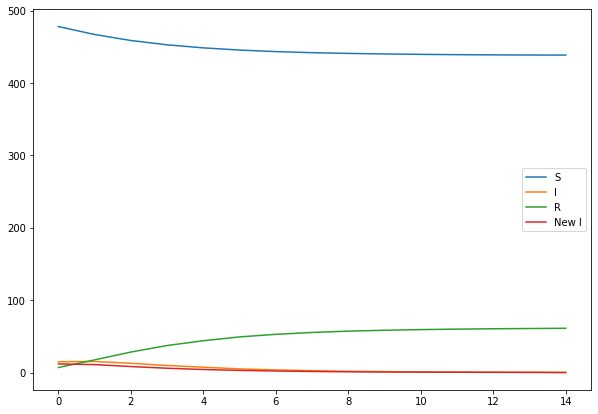

In [114]:
# graph, n_nodes, initial_infected, n_simulations, n_weeks, beta, ro
infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg = simulate(k_regular, n_nodes, 10, 100, 15, 0.3, 0.7)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(susceptible_nodes_avg, label='S')
ax.plot(infected_nodes_avg, label='I')
ax.plot(recovered_nodes_avg, label='R')
ax.plot(new_infected_nodes_avg, label='New I')
ax.legend(loc='best');

### Problem 1.2

In [115]:
def generate_rnd_graph_pa(avg_deg, max_time):

  initial_nodes = avg_deg + 1
  rnd_graph_pa = nx.complete_graph(initial_nodes)  
  #nx.draw_circular(rnd_graph_pa, with_labels=True)

  for t in range(initial_nodes, max_time):

    # compute dinamically c in order to adjust for odd case:
    # take floor when t is even
    # take ceil when t is odd
    if t % 2 == 0:
      c = int(math.floor(avg_deg/2))
    else:
      c = int(math.ceil(avg_deg/2))
    #print(c)
    
    # compute deg distribution at time t-1
    degrees = np.array([d for n, d in rnd_graph_pa.degree()])
    deg_distr = degrees/sum(degrees)
    neighbors = np.random.choice(np.array(rnd_graph_pa.nodes()), p=deg_distr, size=c, replace=False)
    
    # add new node with edges
    node = max(rnd_graph_pa.nodes())+1
    rnd_graph_pa.add_node(node)
    for neigh in neighbors:
        rnd_graph_pa.add_edge(node, neigh) 
  
  return rnd_graph_pa


In [116]:
# checking if it works
k = 10
rnd_graph_pa = generate_rnd_graph_pa(k, 900)
#nx.draw_circular(rnd_graph_pa, with_labels=True)
degrees = np.array([d for n, d in rnd_graph_pa.degree()])
#print(degrees)
print("Average degree: ", np.mean(degrees))
print("Number of nodes: ", rnd_graph_pa.number_of_nodes())

Average degree:  10.0
Number of nodes:  900


In [117]:
# checking if it works also with odd numbers
k = 11
rnd_graph_pa = generate_rnd_graph_pa(k, 900)
#nx.draw_circular(rnd_graph_pa, with_labels=True)
degrees = np.array([d for n, d in rnd_graph_pa.degree()])
#print(degrees)
print("Average degree: ", np.mean(degrees))
print("Number of nodes: ", rnd_graph_pa.number_of_nodes())

Average degree:  11.0
Number of nodes:  900


## 2 Simulate a pandemic without vaccination

### Problem 2

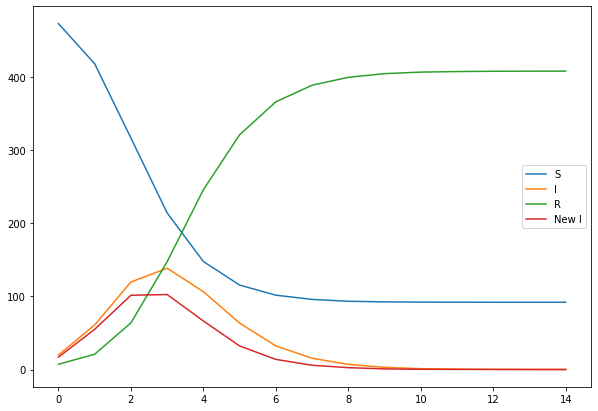

In [119]:
k = 6
max_nodes = 500
n_weeks = 15
beta = 0.3
ro = 0.7
initial_infected = 10
n_iterations = 100

rnd_graph_pa = generate_rnd_graph_pa(k, max_nodes)

infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg = simulate(rnd_graph_pa, max_nodes, initial_infected, n_iterations, n_weeks, beta, ro)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(susceptible_nodes_avg, label='S')
ax.plot(infected_nodes_avg, label='I')
ax.plot(recovered_nodes_avg, label='R')
ax.plot(new_infected_nodes_avg, label='New I')
ax.legend(loc='best');

## 3 Simulate a pandemic with vaccination

### Problem 3

In [194]:
def simulate_vaccination(graph, n_nodes, initial_infected, n_simulations, n_weeks, beta, ro, vacc_t):

  # Vectors for storing a particular type of node:
  # i^th row corresponds to the i^th simulation,
  # j^th column corresponds to the j^th week
  susceptible_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  infected_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  recovered_nodes = np.zeros((n_simulations, n_weeks), dtype=int)
  new_infected_nodes = np.zeros((n_simulations, n_weeks), dtype=int)

  # 10 initial infected nodes at weak 0 of each simulation
  infected_nodes[:, 0] = initial_infected
  new_infected_nodes[:, 0] = initial_infected
  susceptible_nodes[:, 0] = n_nodes - initial_infected
  #recovered_nodes[:, 0] = 0

  vacc_perc = n_nodes * np.array(vacc_t) / 100
  #print(vacc_perc)
  vacc_perc = vacc_perc.astype(int)
  #print(vacc_perc)
  weekly_vacc_perc = vacc_perc.copy()
  weekly_vacc_perc[1:] = weekly_vacc_perc[1:]-weekly_vacc_perc[:-1]

  for simulation in range(n_simulations):
    # The node configuration has a column for the old and the updated configuration
    nodes_configuration = np.zeros((n_nodes, 2), dtype=int)
    # vaccinated nodes at week=0 are 0
    initial_infected_nodes = np.random.choice(graph.nodes, size=(initial_infected,), replace=False)

    for node in initial_infected_nodes:
      nodes_configuration[node, 0] = 1

    for week in range(n_weeks):
      weekly_susceptible_nodes = 0
      weekly_infected_nodes = 0
      weekly_recovered_nodes = 0
      weekly_new_infected_nodes = 0


      if weekly_vacc_perc[week] != 0:
        vaccinated_nodes = np.random.choice(np.argwhere(nodes_configuration[:, 0]!=3).flatten(), size=weekly_vacc_perc[week], replace=False)
        for node in vaccinated_nodes:
          nodes_configuration[node, 0] = 3

      for node in graph.nodes:
        if nodes_configuration[node, 0] == 0:
          m = 0
          # Count neighbours that are I
          for neighbour in graph.neighbors(node):
            if nodes_configuration[neighbour, 0] == 1:
              m+=1
          if np.random.random(1)[0] < (1-beta)**m:
            nodes_configuration[node, 1] = 0
            weekly_susceptible_nodes += 1
          else:
            nodes_configuration[node, 1] = 1
            weekly_infected_nodes += 1
            weekly_new_infected_nodes += 1


        elif nodes_configuration[node, 0] == 1:

          if np.random.random(1)[0]< ro:
            nodes_configuration[node, 1] = 2
            weekly_recovered_nodes += 1
          else:
            nodes_configuration[node, 1] = 1
            weekly_infected_nodes += 1

        elif nodes_configuration[node, 0] == 2:
          nodes_configuration[node, 1] = 2
          weekly_recovered_nodes += 1
        
        else:
          nodes_configuration[node, 1] = 3

      infected_nodes[simulation, week] = weekly_infected_nodes
      susceptible_nodes[simulation, week] = weekly_susceptible_nodes
      recovered_nodes[simulation, week] = weekly_recovered_nodes
      new_infected_nodes[simulation, week] = weekly_new_infected_nodes
      nodes_configuration[:, 0] = nodes_configuration[:, 1]

  infected_nodes_avg = np.mean(infected_nodes, axis=0)
  susceptible_nodes_avg = np.mean(susceptible_nodes, axis=0)
  recovered_nodes_avg = np.mean(recovered_nodes, axis=0)
  new_infected_nodes_avg = np.mean(new_infected_nodes, axis=0) 
  

  return infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg, vacc_perc, weekly_vacc_perc

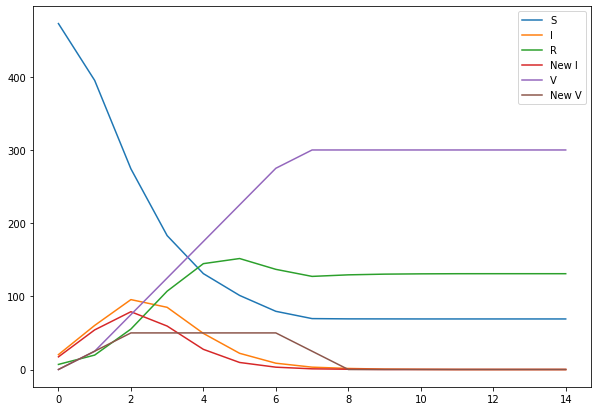

In [195]:
k = 6
max_nodes = 500
n_weeks = 15
beta = 0.3
ro = 0.7
initial_infected = 10
n_iterations = 100
vacc_t = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

rnd_graph_pa = generate_rnd_graph_pa(k, max_nodes)

infected_nodes_avg, susceptible_nodes_avg, recovered_nodes_avg, new_infected_nodes_avg, vacc_perc, weekly_vacc_perc = simulate_vaccination(rnd_graph_pa, max_nodes, initial_infected, n_iterations, n_weeks, beta, ro, vacc_t)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(susceptible_nodes_avg, label='S')
ax.plot(infected_nodes_avg, label='I')
ax.plot(recovered_nodes_avg, label='R')
ax.plot(new_infected_nodes_avg, label='New I')
ax.plot(vacc_perc, label='V')
ax.plot(weekly_vacc_perc, label='New V')
ax.legend(loc='best');